In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import common python libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

matplotlib.rc("figure", figsize=(8, 6))
matplotlib.rc("font", size=14)

colors = cm.tab10(np.linspace(0, 1, 10))

# Prepare training and testing data

In [3]:
df = pd.read_csv("data/aircraft.csv", index_col=0)

train_acs = "A320,A343,A359,A388,B737,B744,B752,B763,B773,B789,C550,E145,E190"
train_acs = train_acs.split(",")

df_train = df.query("index in @train_acs")
df_test = df.query("index not in @train_acs")

x_train = df_train.max_weight.values
y_train = df_train.max_thrust.values

x_test = df_test.max_weight.values
y_test = df_test.max_thrust.values

# Fit linear model using Scikit-Learn

In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
b1 = model.coef_[0].round(2)
b0 = model.intercept_.round(2)

y_pred = model.predict(x_test.reshape(-1, 1))

# Visualize the model and testing data

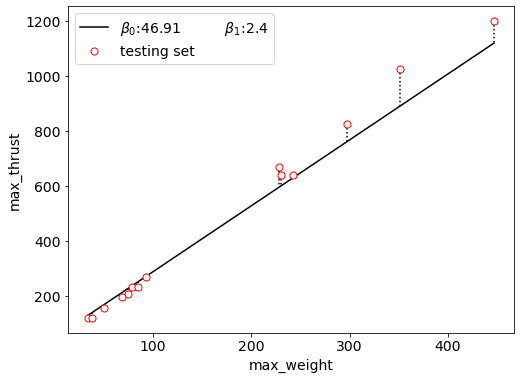

In [5]:
from common import plot_data, plot_linear_model

fig, ax = plt.subplots(1)
plot_data(
    ax,
    df_train,
    df_test,
    xcol="max_weight",
    ycol="max_thrust",
    show_train=False,
    show_test=True,
)
plot_linear_model(ax, b0, b1, x_test, y_test, err=True)

# Plot the prediction error

Error are sorted by their absolute magnitudes.

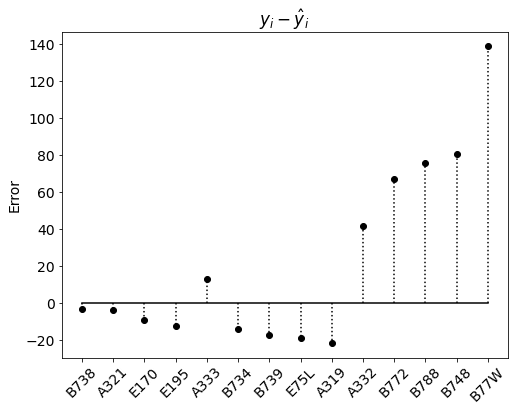

In [6]:
error = y_test - y_pred
test_aircraft = df_test.index.values

order = abs(error).argsort()
test_aircraft = test_aircraft[order]
error = error[order]

plt.stem(error, basefmt="k-", linefmt="k:", markerfmt="ko")
plt.xticks(range(len(test_aircraft)), test_aircraft, rotation=45)
plt.ylabel("Error")
plt.title("$y_i - \hat y_i$")
plt.show()

## Mean Absolute Error (MAE)

The mean absolute error is the average of all absolute differences.

$$
ME = \frac{1}{N} |y_i - \hat y_i|
$$

## Median Absolute Error

The median absolute error is the media value among all absolute differences.

$$
\text{Median of all} \quad |y_i - \hat y_i|
$$

In [7]:
def mean_absolute_error(y, y_hat):
    return np.mean(np.abs(y - y_hat))


def median_absolute_error(y, y_hat):
    return np.median(np.abs(y - y_hat))


mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae.round(2), "(kN)")

medae = median_absolute_error(y_test, y_pred)
print("Median Absolute Error:", medae.round(2), "(kN)")

Mean Absolute Error: 37.02 (kN)
Median Absolute Error: 18.33 (kN)


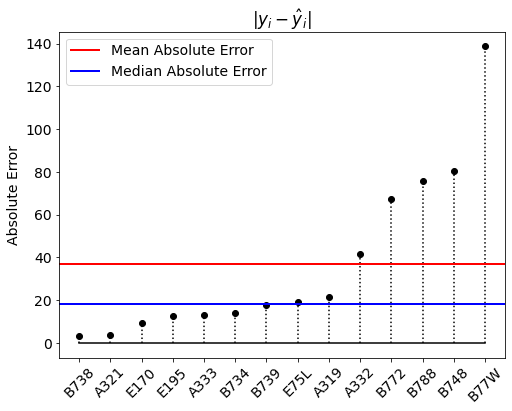

In [8]:
plt.stem(abs(error), basefmt="k-", linefmt="k:", markerfmt="ko")
plt.axhline(mae, color="r", lw=2, label="Mean Absolute Error")
plt.axhline(medae, color="b", lw=2, label="Median Absolute Error")
plt.xticks(range(len(test_aircraft)), test_aircraft, rotation=45)
plt.ylabel("Absolute Error")
plt.title("$|y_i - \hat y_i|$")
plt.legend()
plt.show()

### Mean Squared Error (MSE)

Mean squared error is the average of all squared difference:

$$
MSE = \frac{1}{N} \sum_{i=0}^N ( y_i - \hat y_i )^2
$$

### Root Mean Squared Error (RMSE)

Root mean squared error is the root square of the MSE:

$$
RMSE = \sqrt{\frac{1}{N} \sum_{i=0}^N ( y_i - \hat y_i )^2}
$$

In [9]:
def mean_squared_error(y, y_hat):
    return np.mean((y - y_hat) ** 2)


def root_mean_squared_error(y, y_hat):
    return np.sqrt(np.mean((y - y_hat) ** 2))


mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse.round(2), "(kN^2)")

rmse = root_mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", rmse.round(2), "(kN)")

Mean Squared Error: 2819.68 (kN^2)
Root Mean Squared Error: 53.1 (kN)


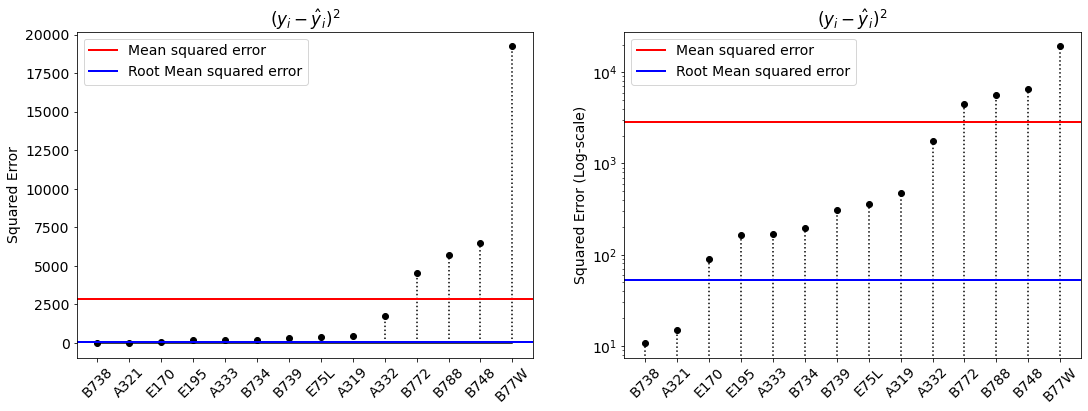

In [10]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.stem(error ** 2, basefmt="k-", linefmt="k:", markerfmt="ko")
plt.xticks(range(len(test_aircraft)), test_aircraft, rotation=45)
plt.axhline(mse, color="r", lw=2, label="Mean squared error")
plt.axhline(rmse, color="b", lw=2, label="Root Mean squared error")
plt.ylabel("Squared Error")
plt.title("$(y_i - \hat y_i)^2$")
plt.legend()

plt.subplot(122)
plt.stem(error ** 2, basefmt="k-", linefmt="k:", markerfmt="ko")
plt.xticks(range(len(test_aircraft)), test_aircraft, rotation=45)
plt.axhline(mse, color="r", lw=2, label="Mean squared error")
plt.axhline(rmse, color="b", lw=2, label="Root Mean squared error")
plt.ylabel("Squared Error (Log-scale)")
plt.title("$(y_i - \hat y_i)^2$")
plt.yscale("log")
plt.legend()

plt.show()

# $R^2$ score (Coefficient of determination)

The $R^2$  score determines the portion of the variance in data, which can be explained by the model predictor(s).

In other words, after we have applied the regression model, how much uncertainty is still left in the data. It is calculated as:

$$
R^2 = \frac{\text{VAR(data)} - \text{VAR(regression)}}{\text{VAR(data)}} = 1 - \frac{\sum (y_i-\hat y_i)^2}{\sum (y_i- \overline y)^2}
$$

A higher $R^2$ score means that the change in data can be well captured by the model predictor(s). 

When calculate $R^2$ score based on trained model and testing data, it show the goodness of model fit. 

$R^2 = 1$ means the perfect fit in theory. $R^2$ can also be negative, which means the model shows the opposite trends of the data.


In [11]:
def r2_score(y, y_hat):
    var_regression = np.mean(np.sum((y - y_hat) ** 2))
    var_data = np.mean(np.sum((y - y.mean()) ** 2))
    r2 = 1 - var_regression / var_data
    return r2


print("R2 Score:", r2_score(y_test, y_pred))

R2 Score: 0.9769301343511592


In [12]:
def stemplot(ax1, ax2, y, y_hat):
    ax1.stem((y - y.mean()) ** 2, basefmt="k-", linefmt="k:", markerfmt="ko")
    ax1.axhline(np.mean((y - y.mean()) ** 2), color="r", lw=2, label="Data variance")
    ax2.set_xticks(range(len(test_aircraft)))
    ax2.set_xticklabels(test_aircraft, rotation=45)
    ax1.set_ylabel("Squared Error")
    ax1.set_title("$(y_i - \\bar y)^2$")
    ax1.legend()

    ax2.stem((y - y_hat) ** 2, basefmt="k-", linefmt="k:", markerfmt="ko")
    ax2.axhline(np.mean((y - y_hat) ** 2), color="r", lw=2, label="Mean squared error")
    ax2.set_xticks(range(len(test_aircraft)))
    ax2.set_xticklabels(test_aircraft, rotation=45)
    ax2.set_ylabel("Squared Error")
    ax2.set_title("$(y_i - \hat y_i)^2$")
    ax2.legend()

## $R^2$ score from our model and testing data

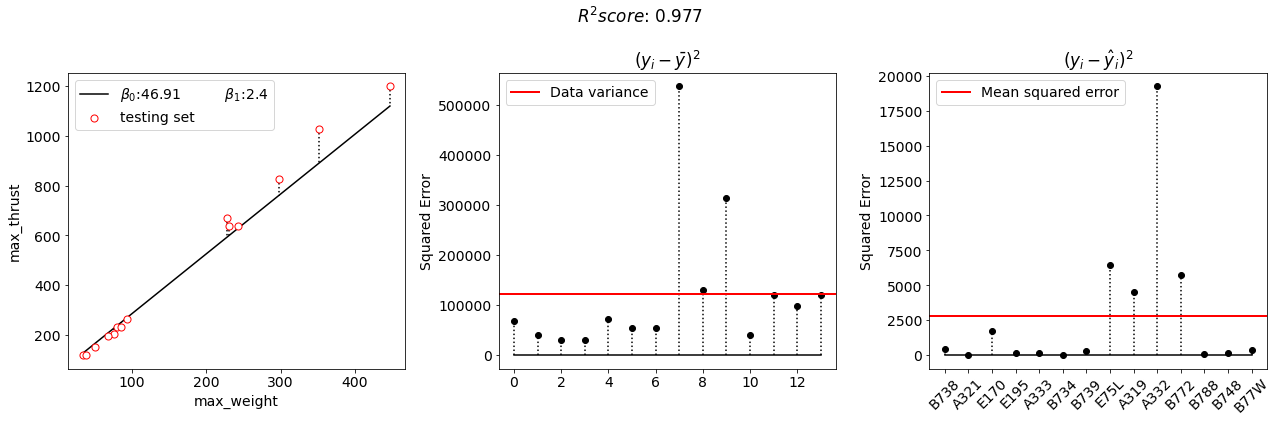

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
plot_data(
    ax[0],
    df_train,
    df_test,
    xcol="max_weight",
    ycol="max_thrust",
    show_train=False,
    show_test=True,
)
plot_linear_model(ax[0], b0, b1, x_test, y_test, err=True)
stemplot(ax[1], ax[2], y_test, y_pred)
plt.suptitle("$R^2 score$: {}".format(r2_score(y_test, y_pred).round(3)))
plt.tight_layout()
plt.show()

## $R^2$ scores based on toy models and testing data

Let's vary the intercept and slope of the linear model to see how $R^2$ score changes.

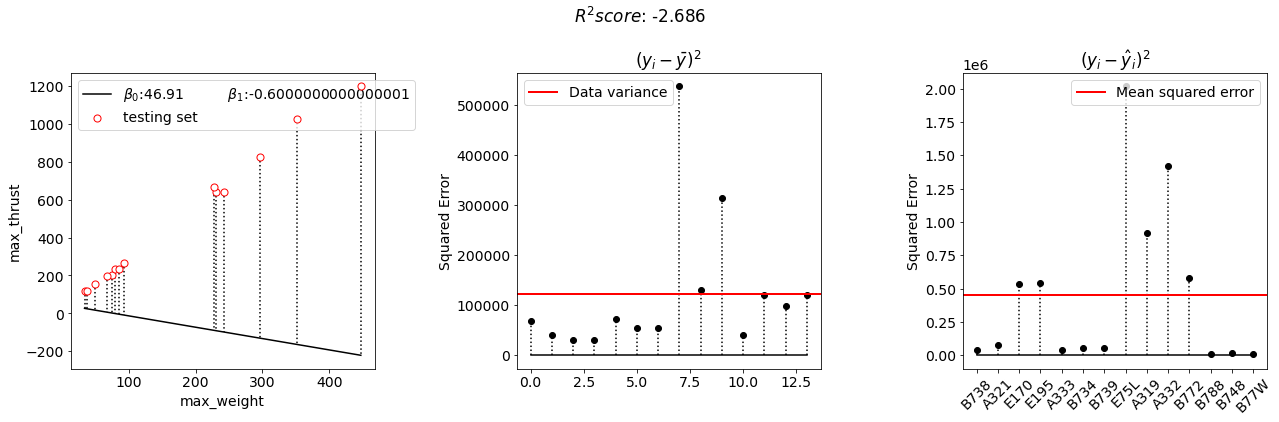

In [14]:
# b1_ = b1 - 1
# b1_ = b1 - 1.3
b1_ = b1 - 3

y_pred_2 = np.poly1d([b1_, b0])(x_test)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
plot_data(
    ax[0],
    df_train,
    df_test,
    xcol="max_weight",
    ycol="max_thrust",
    show_train=False,
    show_test=True,
)
plot_linear_model(ax[0], b0, b1_, x_test, y_test, err=True)

stemplot(ax[1], ax[2], y_test, y_pred_2)

plt.suptitle("$R^2 score$: {}".format(r2_score(y_test, y_pred_2).round(3)))
plt.tight_layout()
plt.show()